# CNN

We're working with multioutput regression to predict a goodness score and confidence score for a whole overhead deepsquat exercise, depending on the variables from the PoseNet model representing joint coordinates and confidence scores, per video frame.
This means that the outputs are dependent upon the input and upon each other. We're required to find a model that predicts both outputs together.

In this Notebook, we're experimenting with 1 dimensional CNNs to find a good-performing model. We're using Conv1D because the input samples consists of sequences of exercise movements, which we can consider as Time-series data. The data represents the movement in 2 axes (X, Y). 1D CNN can perform recognition task from sequential data, such as what position the person has in his exercise and how confident the model is at the position being truthful. This data has 2 dimensions and a confidence score. Kernel moves in one direction.

We're not directly dealing with 2D image data (which would require Conv2D) or video data/3D image data (which would require Conv3D).

In [4]:
# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Set random state
import numpy as np
random_state = 47
np.random.seed(random_state)

# Use GPU (if available)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices( 'GPU' )
print( 'Num GPUs Available: ', len( physical_devices ) )
if len( physical_devices ) > 0:
    tf.config.experimental.set_memory_growth( physical_devices[0], True )

Num GPUs Available:  1


# 1. Data Preparation

## 1.1 Load Dataset

In [5]:
data_path = '../../datasets/'

files = [
    'posenet_scored_all_1.csv',
    'posenet_scored_all_2.csv',
    'posenet_scored_all_3.csv',
    'posenet_scored_all_4.csv',
]

df = None

In [6]:
import pandas as pd

for file in files:
    try:
        dataset = pd.read_csv(data_path + file)
        dataset.drop(columns=['left_eye_x', 'left_eye_y', 'left_eye_score', 'right_eye_x', 'right_eye_y', 'right_eye_score', 
                                'left_ear_x', 'left_ear_y', 'left_ear_score', 'right_ear_x', 'right_ear_y', 'right_ear_score'])
        dataset.rename({'nose_x': 'head_x', 'nose_y': 'head_y', 'nose_score': 'head_score'})

        if df is None:
            df = dataset
        else:
            df = df.append(dataset, ignore_index=True)  

    except IOError as e:
        print('Error in reading file: ', e)

print(df.shape)

(225092, 54)


## 1.2 Train/Val/Test split

In [7]:
X = df.drop(columns=['ConfidenceScore', 'GoodnessScore'])
y = df[['ConfidenceScore', 'GoodnessScore']]

from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=random_state)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

## 1.3 Standardize features and labels

In [9]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')

print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training features shape: (202582, 52)
Training labels shape: (202582, 2) 

Test features shape: (22510, 52)
Test labels shape: (22510, 2)


## 1.4 Reshape data for convolutional layers

In [10]:
original_shape = X_train.shape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

print("Before: {}".format(original_shape))

input_shape = (n_timesteps, n_features)

print("After: {}".format(X_train.shape))

Before: (202582, 52)
After: (202582, 1, 52)


# 2. Define Model Architecture

## 2.1 Model Architecture

The **create_model()** method returns a model with the layers and configurations specified.

The model will optimize the mean squared error (mse) required for regression problems.

In [11]:
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.layers import InputLayer

metrics = [
    MeanSquaredError(name="mse", dtype=None),
    MeanAbsoluteError(name="mae", dtype=None),
    RootMeanSquaredError(name="rmse", dtype=None),
]

def create_model(layers, optimizer):
    model = tf.keras.models.Sequential(
        InputLayer(input_shape=(n_timesteps, n_features))
    )

    for layer in layers:
        model.add(layer)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metrics)

    print(model.summary())

    return model

# 3. Run Experiments

We will use our [MLflow dashboard](http://35.228.45.76:5000/#/) to track the outcome of experimentation runs.

## 3.1 Define a MLflow Experiment

We'll define the running setup and the model signature.

In [12]:
verbose, epochs, batch_size = 1, 100, 32

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [13]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "head_score"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_shoulder_score"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_shoulder_score"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "left_elbow_score"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "right_elbow_score"),
    ColSpec("double", "left_wrist_x"),
    ColSpec("double", "left_wrist_y"),
    ColSpec("double", "left_wrist_score"),
    ColSpec("double", "right_wrist_x"),
    ColSpec("double", "right_wrist_y"),
    ColSpec("double", "right_wrist_score"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "left_hip_score"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "right_hip_score"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "left_knee_score"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "right_knee_score"),
    ColSpec("double", "left_ankle_x"),
    ColSpec("double", "left_ankle_y"),
    ColSpec("double", "left_ankle_score"),
    ColSpec("double", "right_ankle_x"),
    ColSpec("double", "right_ankle_y"),
    ColSpec("double", "right_ankle_score"),
    ColSpec("double", "score")
])
output_schema = Schema([
    ColSpec("double", "ConfidenceScore"),
    ColSpec("double", "GoodnessScore"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

## 3.2 Plot Training History

This method will be used to inspect how the model is learning by showing training and validation loss.

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

## 3.3 Define Evaluation Metrics

We'll use standard regression performance metrics to evaluate model performance.

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

## 3.4 Model Parameters

For each experimentation run, we'll test different values for model parameters with each model architecture we define. These are the parameter values we're using as a starting point:

- We'll begin small kernels, and then increase to larger ones. 
- As for layers, we'll start by using the ReLU activation function and He weight initialization, which we have noticed seem to provide a general good model performance.
- The RMSprop optimizer will be used first as this is a regression problem we're trying to solve, and we'll use a modest learning rate of 0.001 with a large momentum of 0.9 (generally good practices). But we'll also try the Adam optimizer.

As we're experimenting with these values, the results will be shown in [MLflow dashboard](http://35.228.45.76:5000/#/).

In [16]:
from tensorflow.keras.optimizers import RMSprop, Adam

# Parameters
filters = 64
kernel_size = 3

activation = 'relu'
kernel_initializer = 'he_uniform'

pool_size = 2

dense_units = 128

output_activation = 'linear'

# Optimization function
optimizer = 'RMSprop'
learning_rate = 0.001
momentum = 0.9
opt = RMSprop(learning_rate=learning_rate, momentum=momentum)

## 3.5 Baseline model

Now we can start experimenting with the models, and we'll start with a baseline model. The baseline model will establish a minimum model performance to which all other models can be compared. 

For the baseline model, we've been inspired by the general architectural principles of VGG models - but with 1 dimensional convolution. 
This seems like a good starting point because that structure is easy to understand and implement at the same time as it has previously achieved good performance. <br />
The architecture involves stacking convolutional layers with small 3x3 filters followed by a max-pooling layer. Padding is used on the convolutional layers to ensure the height and width of the output feature maps matches the inputs.

The feature maps output from the feature extraction part of this baseline model will be flattened before we can interpret them with two fully connected (Dense) layers, and then output a prediction.

This baseline will also be tested with larger filters as we're experimenting with parameter values.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             10048     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 30,978
Trainable params: 30,978
Non-trainable params: 0
____________________________________________________

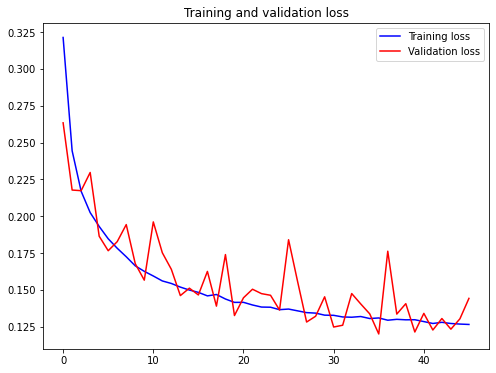

<Figure size 576x432 with 0 Axes>

INFO:tensorflow:Assets written to: C:\Users\angel\AppData\Local\Temp\tmpvyuio125\model\data\model\assets


In [17]:
import time
from tensorflow.keras.layers import Conv1D, Dropout, MaxPool1D, Flatten, Dense

model_name = 'good_ugly_cnn_baseline'

baseline_layers = [
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    #Dropout(0.5),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Flatten(), 
    Dense(dense_units, activation=activation, kernel_initializer=kernel_initializer),
    Dense(n_outputs, activation=output_activation)
]

with mlflow.start_run(run_name=model_name) as run:

    baseline_model = create_model(layers=baseline_layers, optimizer=opt)

    baseline_history = baseline_model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_split=0.2, 
                            shuffle=True, 
                            verbose=verbose, 
                            callbacks=[early_stopping])

    # Plot training history
    plot_train_history(baseline_history, 'Training and validation loss')
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()

    # Log model parameters
    mlflow.log_param("activation", activation)
    mlflow.log_param("kernel_initializer", kernel_initializer)
    mlflow.log_param("output activation", output_activation)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", learning_rate)
    mlflow.log_param("momentum", momentum)
    mlflow.log_param("batch size", batch_size)
    mlflow.log_param("epochs", early_stopping.stopped_epoch)
    mlflow.log_param("filters", filters)
    mlflow.log_param("kernel_size", kernel_size)
    mlflow.log_param("pool size", pool_size)
    mlflow.log_param("total params", baseline_model.count_params())
    mlflow.log_param("units", dense_units)

    # Log model performance
    start_time = time.time()
    predictions = baseline_model.predict(X_test)
    end_time = time.time()
    process_time = (end_time - start_time) * 1000
    predictions = y_scaler.inverse_transform(predictions)
    (mse, mae, r2, variance) = eval_metrics(y_test, predictions)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)
    mlflow.log_metric("process time", process_time)

    # Log model and scaler(s)
    mlflow.keras.log_model(baseline_model, model_name, signature=signature)
    mlflow.sklearn.log_model(X_scaler, 'InputScaler')
    mlflow.sklearn.log_model(y_scaler, 'OutputScaler')

## 3.6 Model 1: 2 Convolutional Blocks

In [15]:
model_name = 'good_ugly_cnn_model1'

model1_layers = [
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Flatten(), 
    Dense(dense_units, activation=activation, kernel_initializer=kernel_initializer),
    Dense(n_outputs, activation=output_activation)
]

with mlflow.start_run(run_name=model_name) as run:

    model1 = create_model(layers=model1_layers, optimizer=opt)

    model1_history = model1.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_split=0.2, 
                            shuffle=True, 
                            verbose=verbose, 
                            callbacks=[early_stopping])

    # Plot training history
    plot_train_history(model1_history, 'Training and validation loss')
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()

    # Log model parameters
    mlflow.log_param("activation", activation)
    mlflow.log_param("kernel_initializer", kernel_initializer)
    mlflow.log_param("output activation", output_activation)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", learning_rate)
    mlflow.log_param("momentum", momentum)
    mlflow.log_param("batch size", batch_size)
    mlflow.log_param("epochs", early_stopping.stopped_epoch)
    mlflow.log_param("filters", filters)
    mlflow.log_param("kernel_size", kernel_size)
    mlflow.log_param("pool size", pool_size)
    mlflow.log_param("total params", model1.count_params())
    mlflow.log_param("units", dense_units)

    # Log model performance
    start_time = time.time()
    predictions = model1.predict(X_test)
    end_time = time.time()
    process_time = (end_time - start_time) * 1000
    predictions = y_scaler.inverse_transform(predictions)
    (mse, mae, r2, variance) = eval_metrics(y_test, predictions)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)
    mlflow.log_metric("process time", process_time)

    # Log model and scaler(s)
    mlflow.keras.log_model(model1, model_name, signature=signature)
    mlflow.sklearn.log_model(X_scaler, 'InputScaler')
    mlflow.sklearn.log_model(y_scaler, 'OutputScaler')

## 3.7 Model 2: 3 Convolutional Blocks

In [ ]:
model_name = 'good_ugly_cnn_model2'

model2_layers = [
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Flatten(), 
    Dense(dense_units, activation=activation, kernel_initializer=kernel_initializer),
    Dense(n_outputs, activation=output_activation)
]

## 3.8 Model 3: 3 Convolutional Blocks + Dropout Regularization

We'll continue with the three convolutional blocks but to try and seek more improvement by using Regularization techniques to avoid overfitting. First, we'll try dropout because it's a simple technique that randomly drop nodes out of the network which forces the remaining nodes to try extra. 

We'll add Dropout to the model by adding Dropout layers after each Max pooling layer and after the fully connected layer. We'll use a fixed dropout rate of 20% so we retain 80% of the nodes.

In [ ]:
model_name = 'good_ugly_cnn_model3'

model3_layers = [
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Dropout(0.2),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Dropout(0.2),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer),
    MaxPool1D(pool_size=pool_size, padding='same'),
    Dropout(0.2),
    Flatten(), 
    Dense(dense_units, activation=activation, kernel_initializer=kernel_initializer),
    Dropout(0.2),
    Dense(n_outputs, activation=output_activation)
]

# 4. Evaluate Model Performances

We'll test the model on the holdout (test) set by making predictions and 

## 4.1 Baseline model performance

In [16]:
baseline_predictions = baseline_model.predict(X_test, batch_size=batch_size, verbose=1)
# Invert transform on predictions
baseline_predictions = y_scaler.inverse_transform(baseline_predictions)

704/704 [==============================] - 1s 1ms/step


In [17]:
(mse, msa, r2, variance) = eval_metrics(y_test, baseline_predictions)

print('MSE: ', mse)
print('MSA: ', msa)
print('R-Squared: ', r2)
print('Explained Variance Score: ', variance)

MSE:  0.21688812685113906
MSA:  0.24023210328449757
R-Squared:  0.6931823846044962
Explained Variance Score:  0.7070996023633889


## 4.2 Model 1 performance

In [18]:
model1_predictions = model1.predict(X_test, batch_size=batch_size, verbose=1)
# Invert transform on predictions
model1_predictions = y_scaler.inverse_transform(model1_predictions)

In [ ]:
(mse, msa, r2, variance) = eval_metrics(y_test, model1_predictions)

print('MSE: ', mse)
print('MSA: ', msa)
print('R-Squared: ', r2)
print('Explained Variance Score: ', variance)

## 4.3 Model 2 performance

In [ ]:
model2_predictions = model2.predict(X_test, batch_size=batch_size, verbose=1)
# Invert transform on predictions
model2_predictions = y_scaler.inverse_transform(model2_predictions)

In [ ]:
(mse, msa, r2, variance) = eval_metrics(y_test, model2_predictions)

print('MSE: ', mse)
print('MSA: ', msa)
print('R-Squared: ', r2)
print('Explained Variance Score: ', variance)

## 4.4 Model 3 performance

In [ ]:
model3_predictions = model3.predict(X_test, batch_size=batch_size, verbose=1)
# Invert transform on predictions
model3_predictions = y_scaler.inverse_transform(model3_predictions)

In [ ]:
(mse, msa, r2, variance) = eval_metrics(y_test, model3_predictions)

print('MSE: ', mse)
print('MSA: ', msa)
print('R-Squared: ', r2)
print('Explained Variance Score: ', variance)

# 5. Register Model(s) (if applicable)

In [19]:
#model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
#mv = mlflow.register_model(model_uri, model_name)
#print("Name: {}".format(mv.name))
#print("Version: {}".format(mv.version))

# 6. Discussion